In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score

import torch
import torch.distributions as D

from clusterless import preprocess
from clusterless import decoder

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [4]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/continuous/'

In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [6]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, split=.8):
        
        self.train_ids = self.rand_trial_ids[:int(split * self.n_trials)]
        self.test_ids = self.rand_trial_ids[int(split * self.n_trials):]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids==idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids==idx for idx in self.test_ids], axis=0).astype(bool)
        train_k_ids, test_k_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_k_ids = [torch.argwhere(torch.tensor(train_k_ids)==k).reshape(-1) for k in self.train_ids]
        train_t_ids = [torch.argwhere(torch.tensor(train_t_ids)==t).reshape(-1) for t in range(self.n_t_bins)]
        test_k_ids = [torch.argwhere(torch.tensor(test_k_ids)==k).reshape(-1) for k in self.test_ids]
        test_t_ids = [torch.argwhere(torch.tensor(test_t_ids)==t).reshape(-1) for t in range(self.n_t_bins)]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_k_ids, train_t_ids, \
               test_trials, test_k_ids, test_t_ids

In [7]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = wheel_velocity, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [8]:
train_trials, train_k_ids, train_t_ids, _, _, _ = data_loader.split_train_test(split=.2)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
train_trials.shape

(150144, 3)

In [10]:
gmm = GaussianMixture(n_components=30, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=0)
gmm.fit(train_trials)

GaussianMixture(init_params='k-means++', n_components=30)

In [11]:
s = torch.tensor(train_trials)
y = torch.tensor(data_loader.y_train)

Nk = len(data_loader.train_ids)
Nt = data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]

#### CAVI-SGD

In [12]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [13]:
class CAVI(torch.nn.Module):

    def __init__(self, Nk, Nt, Nc, Nd, init_means, init_covs, ks, ts):
        super(CAVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        self.ks = ks
        self.ts = ts
        
        # initialize variables for variational distribution
        self.means = torch.nn.Parameter(torch.tensor(init_means))
        self.covs = torch.nn.Parameter(torch.tensor(init_covs))
        self.bs = torch.nn.Parameter(torch.randn((Nc)))
        self.betas = torch.nn.Parameter(torch.randn((Nc, Nt, Nt)))
        
        
    def forward(self, s, y):
        
        # compute log-lambdas
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.bs + self.betas[:,t] @ y[k]
        
        # compute mixing proportions 
        log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
        
        # compute log-likelihood
        ll = torch.zeros((s.shape[0], self.Nc))
        for j in range(self.Nc):
            ll[:,j] = D.multivariate_normal.MultivariateNormal(
                            loc=self.means[j], 
                            covariance_matrix=self.covs[j]
                        ).log_prob(s)
        
        # order of update is: E step -> compute ELBO -> M step
        # E step: compute q(z)
        r = torch.zeros((s.shape[0], self.Nc))
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = np.intersect1d(self.ks[k], self.ts[t])
                r[k_t_idx] = torch.exp( ll[k_t_idx] + log_pis[k,:,t] )
                r[k_t_idx] = torch.einsum('ij,i->ij', r[k_t_idx], 1/r[k_t_idx].sum(1))
                    
        # compute ELBO
        elbo_1 = torch.einsum('ij,ij->', r, ll)
                
        elbo_2 = torch.tensor([ 
                torch.sum( r[np.intersect1d(self.ks[k], self.ts[t])] * log_pis[k,:,t] ) \
                for t in range(Nt) for k in range(Nk)
             ]).sum()
                
        elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)
        
        # M step is done via back propagation
                
        return elbo_1 + elbo_2 + elbo_3

In [14]:
cavi = CAVI(Nk, Nt, Nc, Nd, gmm.means_, gmm.covariances_, train_k_ids, train_t_ids)
optim = torch.optim.Adam(cavi.parameters(), lr=1e-2)

In [ ]:
%%time
max_iter = 200
elbos = []
for i in range(max_iter):
    elbo = cavi(s, y)
    loss = - elbo 
    print(f'iter: {i+1} elbo: {elbo:.2f}')
    elbos.append(elbo)
    optim.zero_grad()
    loss.backward()
    optim.step()

iter: 1 elbo: -3860977.10
iter: 2 elbo: -3843974.44
iter: 3 elbo: -3827457.72
iter: 4 elbo: -3811265.39
iter: 5 elbo: -3795336.96
iter: 6 elbo: -3779645.49
iter: 7 elbo: -3764209.59
iter: 8 elbo: -3749123.47
iter: 9 elbo: -3734541.52
iter: 10 elbo: -3720609.51
iter: 11 elbo: -3707474.13
iter: 12 elbo: -3695252.66
iter: 13 elbo: -3683928.68
iter: 14 elbo: -3673340.30
iter: 15 elbo: -3663344.94
iter: 16 elbo: -3653869.05
iter: 17 elbo: -3644825.19
iter: 18 elbo: -3636105.94
iter: 19 elbo: -3627615.96
iter: 20 elbo: -3619260.37
iter: 21 elbo: -3610948.04
iter: 22 elbo: -3602631.50
iter: 23 elbo: -3594300.33
iter: 24 elbo: -3585973.90
iter: 25 elbo: -3577700.50
iter: 26 elbo: -3569525.32
iter: 27 elbo: -3561485.90
iter: 28 elbo: -3553578.07
iter: 29 elbo: -3545750.95
iter: 30 elbo: -3537954.14
iter: 31 elbo: -3530157.20
iter: 32 elbo: -3522350.53
iter: 33 elbo: -3514540.97
iter: 34 elbo: -3506762.17
iter: 35 elbo: -3499053.59
iter: 36 elbo: -3491435.89
iter: 37 elbo: -3483927.81
iter: 38 e

In [ ]:
elbos = [elbo.detach().numpy() for elbo in elbos]

In [ ]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [ ]:
log_lambdas = torch.zeros((Nk, Nc, Nt))
for k in range(Nk):
    for t in range(Nt):
        log_lambdas[k,:,t] = cavi.bs + cavi.betas[:,t] @ y[k]

log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(log_pis[2]).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(cavi.betas[:,1].mean(0).detach().numpy());

In [ ]:
gmm.means_

In [ ]:
cavi.means

In [ ]:
cont_y_enc_res = {
    'bs': cavi.bs,
    'betas': cavi.betas,
    'means': cavi.means,
    'covs': cavi.covs
}
np.save(save_path + f'cont_y_enc_res_c{len(cavi.means)}.npy', cont_y_enc_res)

#### MoG only

In [136]:
all_trials = np.concatenate(np.concatenate(data_loader.trials))
spike_times = data_loader.data[:,0]

spike_labels = []
spike_probs = []
spike_labels.extend(gmm.predict(all_trials))
spike_probs.extend(gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [137]:
enc_gmm = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    data_loader.stim_on_times,
    'clusterless', 
    n_time_bins=data_loader.n_t_bins
)
print(enc_gmm.shape)

(265, 50, 30)


In [138]:
windowed_enc_gmm, half_window_size, n_windows = decoder.sliding_window(
    enc_gmm, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [139]:
train = np.arange(data_loader.n_trials)[:int(.8*data_loader.n_trials)]
test = np.arange(data_loader.n_trials)[int(.8*data_loader.n_trials):]

x_by_trial = windowed_enc_gmm.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_gmm.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_gmm.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [140]:
r2_score(y_test, y_pred)

0.16557535503633325

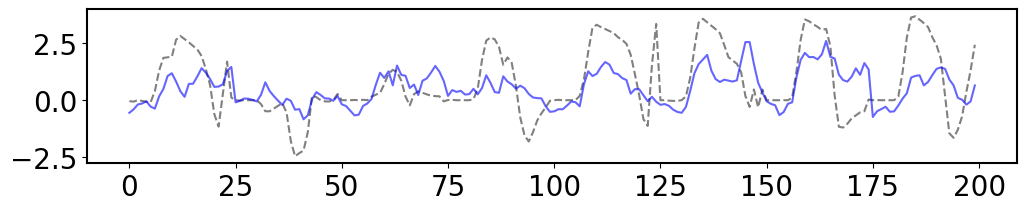

In [141]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');
# plt.legend();

#### encoding MoG

In [142]:
x_train = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[train]
x_test = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [143]:
r2_score(data_loader.y[test], y_hat)

-0.004741917218232712

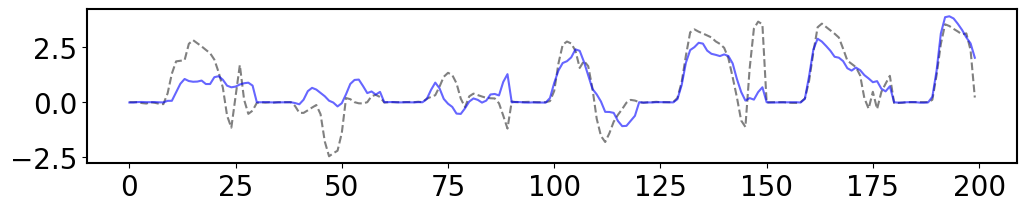

In [144]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [145]:
log_lambdas_hat = np.zeros((data_loader.n_trials, Nc, Nt))
for k in range(len(train)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = cavi.bs.detach().numpy() + cavi.betas[:,t].detach().numpy() @ y_train[k]

for k in range(len(test)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = cavi.bs.detach().numpy() + cavi.betas[:,t].detach().numpy() @ y_hat[k]

log_pis_hat = log_lambdas_hat - logsumexp(log_lambdas_hat, 1)[:,None,:]

In [146]:
enc_pis = np.exp(log_pis_hat)
enc_means = cavi.means.detach().numpy()
enc_covs = cavi.covs.detach().numpy()

In [147]:
all_data = []
for k in range(data_loader.n_trials):
    mask = np.logical_and(
        data_loader.data[:,0] >= data_loader.stim_on_times[k]-0.5,
        data_loader.data[:,0] <= data_loader.stim_on_times[k]+1
        )
    trial = data_loader.data[mask]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    t_bins = np.digitize(trial[:,0], data_loader.t_binning, right=False)-1
    t_bins_lst = []
    for t in range(data_loader.n_t_bins):
        t_bin = trial[t_bins == t, 1:]
        t_bins_lst.append(t_bin)
    all_data.append(t_bins_lst)

In [148]:
enc_all = np.zeros((data_loader.n_trials, Nc, Nt))

for k in range(enc_all.shape[0]):
    for t in range(Nt):
        enc_gmm =  GaussianMixture(n_components=Nc, covariance_type='full')
        enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        enc_gmm.weights_ = enc_pis[k,:,t]
        enc_gmm.means_ = enc_means
        enc_gmm.covariances_ = enc_covs
        enc_all[k,:,t] = enc_gmm.predict_proba(all_data[k][t]).sum(0)

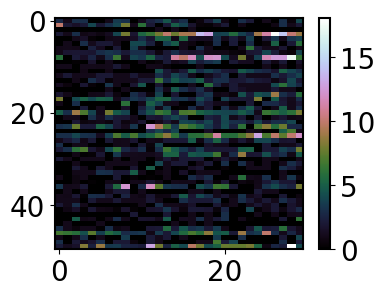

In [153]:
plt.figure(figsize=(4,3))
plt.imshow(enc_all[3], 
           aspect='auto', cmap='cubehelix')
plt.colorbar();

In [154]:
windowed_enc_all, half_window_size, n_windows = decoder.sliding_window(
    enc_all, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [155]:
x_by_trial = windowed_enc_all.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_all.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_all.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [156]:
ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [157]:
r2_score(y_test, y_pred)

0.11668758841120952

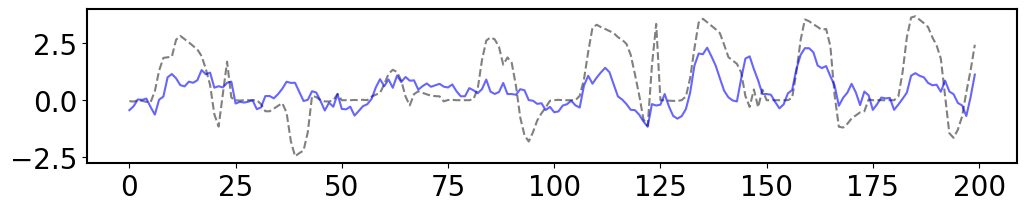

In [158]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');
# plt.legend();

#### KS & good IBL units

In [57]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)
good sorted neural data shape: (265, 83, 30)


In [58]:
windowed_sorted, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)

windowed_good_units, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [59]:
x_by_trial = windowed_sorted.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_sorted.shape[1]))
x_test = x_test.reshape((-1, windowed_sorted.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [60]:
r2_score(y_test, y_pred)

0.2891548796403589

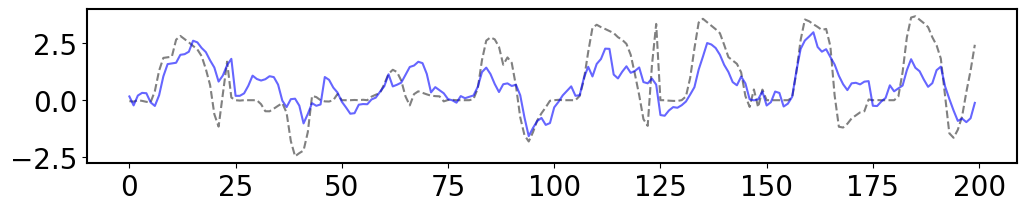

In [61]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');
# plt.legend();

In [64]:
x_by_trial = windowed_good_units.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_good_units.shape[1]))
x_test = x_test.reshape((-1, windowed_good_units.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [65]:
r2_score(y_test, y_pred)

0.16312750031178835

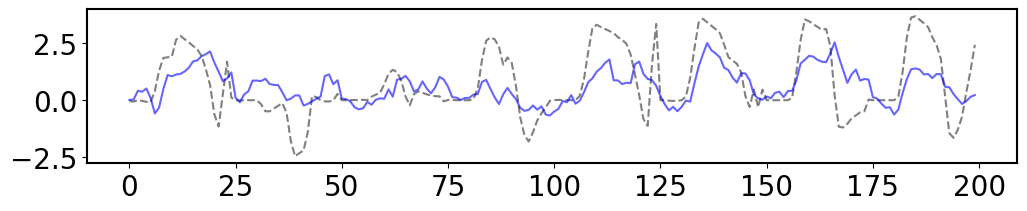

In [66]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');
# plt.legend();